In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import datasets
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
from PIL import Image

In [4]:
data_dir = '/content/drive/MyDrive/Miniproject/chest_xray/Dataset'

In [5]:
import pathlib
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*/*')))
print(image_count)

5866


In [6]:
img = cv2.imread('/content/drive/MyDrive/Miniproject/chest_xray/Dataset/train/NORMAL/IM-0115-0001.jpeg')
img.shape

(1858, 2090, 3)

In [7]:
filepath = '/content/drive/MyDrive/Miniproject/chest_xray/Dataset/train/NORMAL/IM-0115-0001.jpeg'
img = tf.io.read_file(filepath)
img = tf.io.decode_jpeg(img, channels=1)
print(img.shape)
#print(tf.image.resize(img, [img_height, img_width]))


(1858, 2090, 1)


In [8]:
# Reading both normal and pneumonia files into a single object
train_ds_list = tf.data.Dataset.list_files(str(data_dir) +'/train/*/*', shuffle=True, seed = 0)
val_ds_list = tf.data.Dataset.list_files(str(data_dir) + '/val/*/*', shuffle= True, seed = 0)
test_ds_list = tf.data.Dataset.list_files(str(data_dir) + '/test/*/*', shuffle= True, seed = 0)

In [9]:
img_height = 256
img_width = 256
batch_size = 32

In [10]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=1)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  #label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img#, label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_list.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds_list.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds_list.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
rNr = tf.keras.Sequential([layers.Rescaling(1./255), #Rescaling
                           #layers.Flatten(),
                           layers.Flatten()]) # Reshaping

In [12]:
def configure_for_performance(ds):
  ds = ds.batch(batch_size)
  ds = ds.map(lambda x: (rNr(x), rNr(x)), 
              num_parallel_calls=AUTOTUNE)  
  ds = ds.cache()
  #ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [13]:
#encoder = tf.keras.Sequential([
#    tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(256, 7, activation='relu',name='encoder_conv_1'),
#   tf.keras.layers.Conv2D(128, 5, activation='relu',name='encoder_conv_2'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(128, 5, activation='relu',name='encoder_conv_3'),
#   tf.keras.layers.Conv2D(128, 5, activation='relu',name='encoder_conv_4'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

In [14]:

# Encoder
x = tf.keras.layers.Input(shape=(img_height*img_width), name="encoder_input")

encoder_dense_layer1 = tf.keras.layers.Dense(units=1024, name="encoder_dense_1")(x)
encoder_activ_layer1 = tf.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_dense_layer1)

encoder_dense_layer2 = tf.keras.layers.Dense(units=512, name="encoder_dense_2")(encoder_activ_layer1)
encoder_activ_layer2 = tf.keras.layers.LeakyReLU(name="encoder_leakyrelu_2")(encoder_dense_layer2)

encoder_dense_layer3 = tf.keras.layers.Dense(units=128, name="encoder_dense_3")(encoder_activ_layer2)
encoder_output = tf.keras.layers.LeakyReLU(name="encoder_output")(encoder_dense_layer3)

encoder = tf.keras.models.Model(x, encoder_output, name="encoder_model")
encoder.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 65536)]           0         
                                                                 
 encoder_dense_1 (Dense)     (None, 1024)              67109888  
                                                                 
 encoder_leakyrelu_1 (LeakyR  (None, 1024)             0         
 eLU)                                                            
                                                                 
 encoder_dense_2 (Dense)     (None, 512)               524800    
                                                                 
 encoder_leakyrelu_2 (LeakyR  (None, 512)              0         
 eLU)                                                            
                                                                 
 encoder_dense_3 (Dense)     (None, 128)             

In [15]:
# Decoder
decoder_input = tf.keras.layers.Input(shape=(128), name="decoder_input")

decoder_dense_layer1 = tf.keras.layers.Dense(units=512, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = tf.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_dense_layer1)

decoder_dense_layer2 = tf.keras.layers.Dense(units=1024, name="decoder_dense_2")(decoder_activ_layer1)
decoder_activ_layer2 = tf.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_dense_layer2)

decoder_dense_layer3 = tf.keras.layers.Dense(units=img_height*img_width, name="decoder_dense_3")(decoder_activ_layer2)
decoder_output = tf.keras.layers.LeakyReLU(name="decoder_output")(decoder_dense_layer3)

decoder = tf.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 128)]             0         
                                                                 
 decoder_dense_1 (Dense)     (None, 512)               66048     
                                                                 
 decoder_leakyrelu_1 (LeakyR  (None, 512)              0         
 eLU)                                                            
                                                                 
 decoder_dense_2 (Dense)     (None, 1024)              525312    
                                                                 
 decoder_leakyrelu_2 (LeakyR  (None, 1024)             0         
 eLU)                                                            
                                                                 
 decoder_dense_3 (Dense)     (None, 65536)           

In [16]:
# Autoencoder
ae_input = tf.keras.layers.Input(shape=(img_height*img_width), name="autoencoder_input")
ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = tf.keras.models.Model(ae_input, ae_decoder_output, name="autoencoder")
ae.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLay  [(None, 65536)]          0         
 er)                                                             
                                                                 
 encoder_model (Functional)  (None, 128)               67700352  
                                                                 
 decoder_model (Functional)  (None, 65536)             67765760  
                                                                 
Total params: 135,466,112
Trainable params: 135,466,112
Non-trainable params: 0
_________________________________________________________________


In [17]:
# RMSE
def rmse(y_true, y_predict):
    return tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict))

# AE Compilation
ae.compile(loss="mse", optimizer=tf.keras.optimizers.Adam()) #learning_rate=0.0005

In [19]:
def customIoU(y_true, y_pred):
    nonzero_off = 1e-5
    y_true_f = y_true#tf.keras.backend.flatten(y_true[:,:,:,0])
    y_pred_f = y_pred#tf.keras.backend.flatten(y_pred[:,:,:,0])
    #Compute intersection score in flattened vectors by dot mul
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f*y_true_f) + tf.keras.backend.sum(y_pred_f*y_pred_f) - intersection 
    iou = intersection/(union + nonzero_off)
    return iou

# from keras.models import load_model
# m1test = load_model("/content/drive/MyDrive/Miniproject/chest_xray/NN/weights/weights_best_1.hdf5", compile=False)
# m1test.compile(metrics=[customIoU])  #NO loss metric given to compile
# m1test.evaluate(test_ds)

20/20 [==============================] - 80s 4s/step - loss: 0.0000e+00 - customIoU: 0.9813


[0.0, 0.9812841415405273]

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

wtpath="/content/drive/MyDrive/Miniproject/chest_xray/NN/weights/weights_best_1.hdf5"
checkpoint = ModelCheckpoint(wtpath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=5,mode='min')
callbacks_list = [checkpoint,es]

In [22]:
# Training AE
hist = ae.fit(train_ds, 
       epochs=50, 
       batch_size=batch_size, 
       #shuffle=True, 
       validation_data = test_ds,
       callbacks=callbacks_list)

Epoch 1/50
164/164 [==============================] - ETA: 0s - loss: 2.0033
Epoch 1: val_loss improved from inf to 0.01904, saving model to /content/drive/MyDrive/Miniproject/chest_xray/NN/weights/weights_best_1.hdf5
164/164 [==============================] - 701s 4s/step - loss: 2.0033 - val_loss: 0.0190
Epoch 2/50
164/164 [==============================] - ETA: 0s - loss: 0.0197
Epoch 2: val_loss improved from 0.01904 to 0.01788, saving model to /content/drive/MyDrive/Miniproject/chest_xray/NN/weights/weights_best_1.hdf5
164/164 [==============================] - 275s 2s/step - loss: 0.0197 - val_loss: 0.0179
Epoch 3/50
164/164 [==============================] - ETA: 0s - loss: 0.0173
Epoch 3: val_loss improved from 0.01788 to 0.01639, saving model to /content/drive/MyDrive/Miniproject/chest_xray/NN/weights/weights_best_1.hdf5
164/164 [==============================] - 288s 2s/step - loss: 0.0173 - val_loss: 0.0164
Epoch 4/50
164/164 [==============================] - ETA: 0s - loss

In [23]:
ae.save('/content/drive/MyDrive/Miniproject/chest_xray/NN/weights/ae_last.hdf5')  # creates a HDF5 file 'my_model.h5'

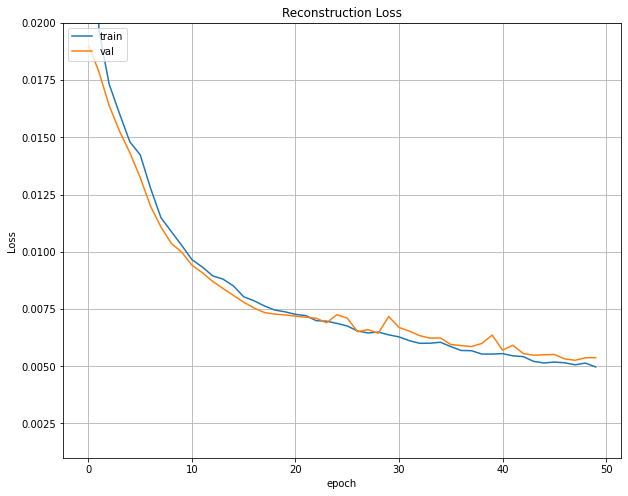

In [28]:
plt.figure(figsize=(10,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Reconstruction Loss')
plt.ylabel('Loss')
plt.ylim(top=0.02,bottom = 0.001)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/NN/loss1.jpg')
plt.show()

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Reconstruction Loss')
plt.ylabel('Loss')
#plt.ylim(top=0.02,bottom = 0.001)
plt.autoscale()
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/NN/loss1.jpg')
plt.show()

In [ ]:
ae.predict?

In [ ]:
test_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 65536), dtype=tf.float32, name=None), TensorSpec(shape=(None, 65536), dtype=tf.float32, name=None))>

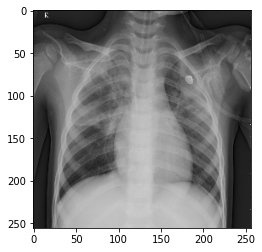

In [30]:
for batch in test_ds.take(1):
    #print(image[0].shape)
    image = batch[0][0]
    plt.imshow(image.numpy().reshape(256,256),'gray')
    plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/NN/True1.jpg')

In [32]:
cv2.imwrite('/content/drive/MyDrive/Miniproject/chest_xray/NN/True1.png',image.numpy().reshape(256,256))

True

True

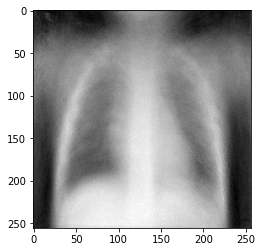

In [31]:
pred_ds = ae.predict(test_ds)
rec = pred_ds[0]
plt.imshow(rec.reshape(256,256),'gray')
#plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/NN/Reconstruction.png')
cv2.imwrite('/content/drive/MyDrive/Miniproject/chest_xray/NN/Reconstruction1.png',rec.reshape(256,256))

In [33]:
diff = image - rec
np.mean(np.square(diff.numpy()))

0.0041342955

In [ ]:
np.sqrt(0.00587*255*255)

19.537060935565513

True

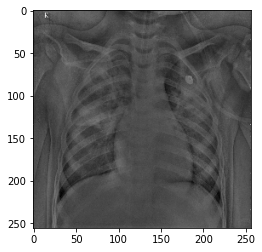

In [34]:
plt.imshow(diff.numpy().reshape(256,256),'gray')
#plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/NN/Delta.jpg')
cv2.imwrite('/content/drive/MyDrive/Miniproject/chest_xray/NN/Delta1.png',diff.numpy().reshape(256,256))

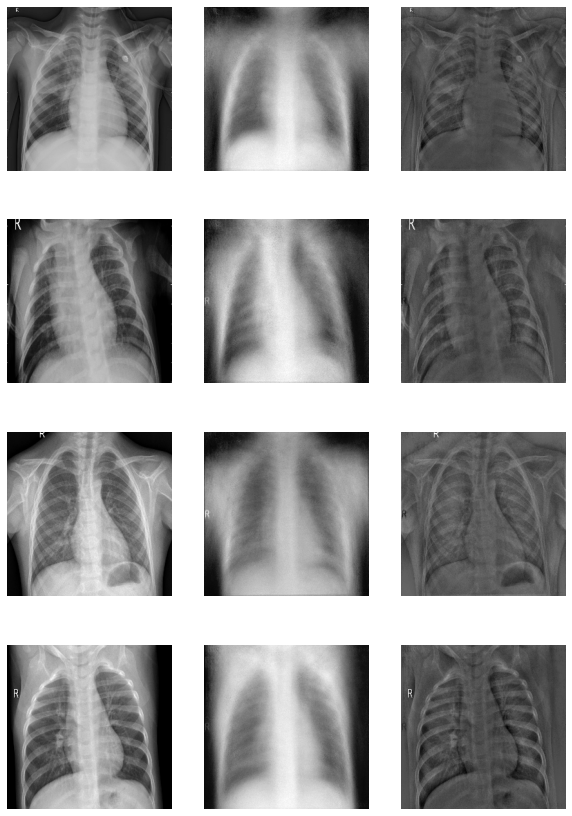

In [35]:
plt.figure(figsize=(10,15)) 
num_images_to_show = 4
for im_ind in range(num_images_to_show):
    plot_ind = im_ind*3 + 1
    #rand_ind = np.random.randint(low=0, high=x_train.shape[0])
    plt.subplot(num_images_to_show, 3, plot_ind)
    for batch in test_ds.take(1):
        image = batch[0][im_ind]
        plt.imshow(image.numpy().reshape(256,256),'gray')
        plt.axis('off')
    rec = pred_ds[im_ind]
    plt.subplot(num_images_to_show, 3, plot_ind+1)
    plt.imshow(rec.reshape(256,256),'gray')
    plt.axis('off')
    plt.subplot(num_images_to_show, 3, plot_ind+2)
    diff = image - rec
    plt.imshow(diff.numpy().reshape(256,256),'gray')
    plt.axis('off')
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.5, 
#                     top=0.2, 
#                     wspace=0.5, 
#                     hspace=0.5)
plt.savefig('/content/drive/MyDrive/Miniproject/chest_xray/NN/summary1.png')

In [ ]:
dummy = tf.keras.models.load_model("/content/drive/MyDrive/Miniproject/chest_xray/NN/weights/weights_best.hdf5")

In [ ]:
dummy.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLay  [(None, 65536)]          0         
 er)                                                             
                                                                 
 encoder_model (Functional)  (None, 128)               67700352  
                                                                 
 decoder_model (Functional)  (None, 65536)             67765760  
                                                                 
Total params: 135,466,112
Trainable params: 135,466,112
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.models import Model

In [ ]:
chen = Model(dummy.layers[1].input,dummy.layers[1].output)

In [ ]:
chde = Model(dummy.layers[-1].input,dummy.layers[-1].output)

#Load model

In [13]:
from keras.models import load_model
m1test = load_model("/content/drive/MyDrive/Miniproject/chest_xray/NN/weights/weights_best_1.hdf5", compile=False)

In [15]:
for batchs in test_ds.take(1):
    #print(image[0].shape)
    batch = batchs[0]

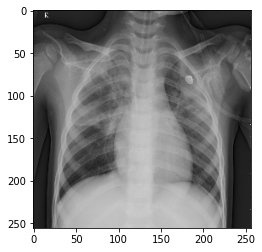

In [17]:
plt.imshow(batch[0].numpy().reshape(256,256)*255,'gray')

In [19]:
cv2.imwrite("/content/drive/MyDrive/Miniproject/chest_xray/NN/True.png",batch[0].numpy().reshape(256,256)*255)

True

In [21]:
rec_ds = m1test.predict(test_ds)

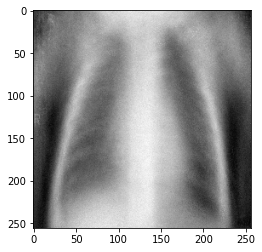

In [22]:
rec = rec_ds[0]
plt.imshow(rec.reshape(256,256)*255,'gray')

In [24]:
cv2.imwrite("/content/drive/MyDrive/Miniproject/chest_xray/NN/ReconstructionNN.png",rec.reshape(256,256)*255)

True

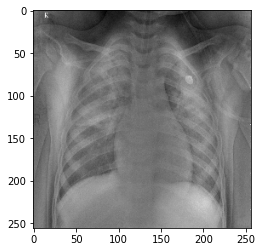

In [25]:
delta = batch[0].numpy().reshape(256,256)*255 - rec.reshape(256,256)*255
plt.imshow(delta,'gray')

In [31]:
low = np.min(delta)
hi = np.max(delta)

delta8 = (delta - low)/(hi - low)*255

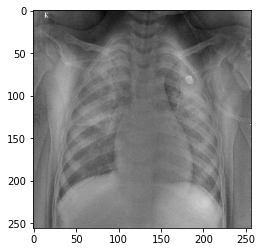

In [32]:
plt.imshow(delta8,'gray')

In [34]:
cv2.imwrite("/content/drive/MyDrive/Miniproject/chest_xray/NN/DeltaNN.png",delta8)

True

In [37]:
np.save("/content/drive/MyDrive/Miniproject/chest_xray/NN/DeltaNN.npy",delta8)